In [1]:
#We analyzed 2020–2023 Travis County data using multiple regression models to understand why cases rose or fell.
#The models show that higher mask adherence had a consistent negative relationship with case counts, particularly in 2020–2021.
#Polynomial and interaction models captured how trends flattened as vaccines rolled out and behavior stabilized.
#Overall, regression helped us see the human and behavioral factors behind the pandemic data — complementing the forecasting done by my teammate.
    
# =============================================
# COVID-19 Regression Storyline – Travis County
# =============================================

# --- Import Libraries ---
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [4]:
# --- 1️⃣ Load Data ---
mask = pd.read_csv("C:/Users/shiva/Datasets/travis_county_mask_usage.csv")   # COUNTYFP, NEVER, RARELY, SOMETIMES, FREQUENTLY, ALWAYS
covid = pd.read_csv("C:/Users/shiva/Datasets/travis_county_covid_weekly.csv") # date, cases, cases_avg, deaths, etc.
mask.head()

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,48453,0.015,0.008,0.024,0.158,0.795


In [5]:
covid.head()

,date,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k
0,2020-03-15,6,2.00,0.15,0,0.00,0.00
1,2020-03-22,73,23.69,1.87,0,0.00,0.00
2,2020-03-29,100,104.74,8.23,1,0.09,0.00
3,2020-04-05,281,174.80,13.72,5,0.81,0.09
4,2020-04-12,314,300.15,23.56,3,1.69,0.14


In [6]:
# --- 2️⃣ Merge & Prepare ---
covid["COUNTYFP"] = 48453  # Travis County FIPS
df = covid.merge(mask, on="COUNTYFP", how="left")

df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

In [7]:
# --- 3️⃣ Feature Engineering ---
df["cases_avg_lag1"] = df["cases_avg"].shift(1)
df["case_growth"] = df["cases_avg"].pct_change()
df["week_num"] = range(1, len(df)+1)
df["week_squared"] = df["week_num"]**2
df["mask_effect"] = df["ALWAYS"] * df["cases_avg_lag1"]
df = df.dropna()

mask_vars = ["NEVER","RARELY","SOMETIMES","FREQUENTLY","ALWAYS"]


In [8]:
# --- 4️⃣ Helper Function ---
def run_model(y, X, label):
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    print(f"\n{'='*20}\n{label} Model Summary\n{'='*20}")
    print(model.summary())
    return model

In [9]:
# --- 5️⃣ Regression Models ---

# Base model (weekly continuity only)
model_base = run_model(df["cases_avg"], df[["cases_avg_lag1"]], "Base")

# Mask usage model (behavioral effect)
model_mask = run_model(df["cases_avg"], df[["cases_avg_lag1"] + mask_vars], "Mask Usage")

# Log-linear model (exponential phase control)
df["log_cases_avg"] = np.log(df["cases_avg"])
model_log = run_model(df["log_cases_avg"], df[["cases_avg_lag1"] + mask_vars], "Log-linear")

# Polynomial trend model (time trend)
model_poly = run_model(df["cases_avg"], df[["cases_avg_lag1", "week_num", "week_squared", "ALWAYS"]], "Polynomial Trend")

# Interaction model (behavioral moderation)
model_interact = run_model(df["cases_avg"], df[["cases_avg_lag1", "mask_effect", "ALWAYS"]], "Interaction")


Base Model Summary
                            OLS Regression Results                            
Dep. Variable:              cases_avg   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     682.1
Date:                Sat, 01 Nov 2025   Prob (F-statistic):           7.83e-59
Time:                        18:44:17   Log-Likelihood:                -1331.9
No. Observations:                 158   AIC:                             2668.
Df Residuals:                     156   BIC:                             2674.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            181.891

In [10]:
# --- 6️⃣ Model Comparison ---
models = {
    "Base": model_base,
    "Mask": model_mask,
    "Log-linear": model_log,
    "Polynomial": model_poly,
    "Interaction": model_interact
}

print("\nModel Comparison (R² and AIC):")
for name, m in models.items():
    print(f"{name:<15} R² = {m.rsquared:.3f} | AIC = {m.aic:.1f}")


Model Comparison (R² and AIC):
Base            R² = 0.814 | AIC = 2667.9
Mask            R² = 0.814 | AIC = 2667.9
Log-linear      R² = 0.512 | AIC = 335.5
Polynomial      R² = 0.815 | AIC = 2671.2
Interaction     R² = 0.814 | AIC = 2667.9


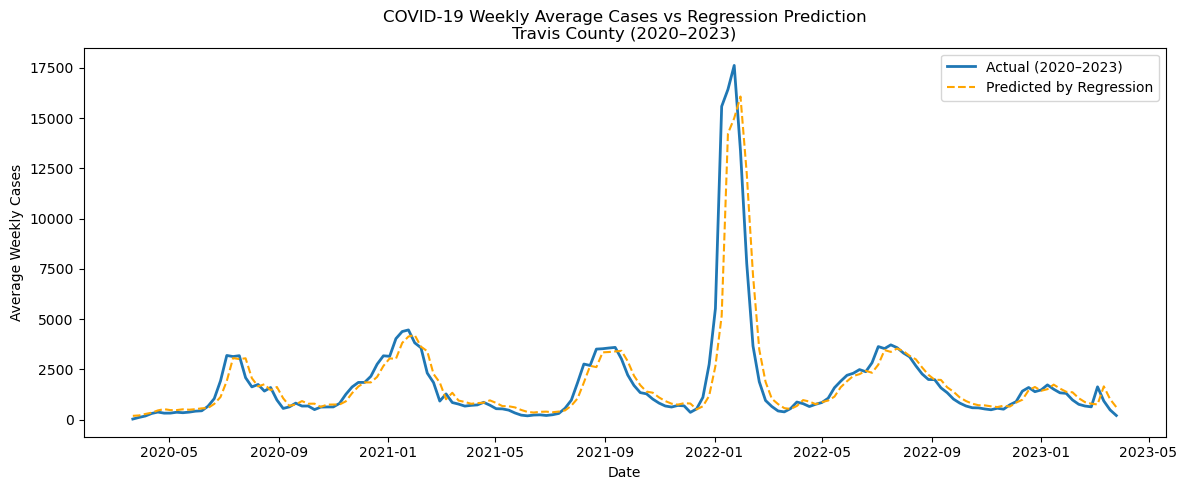

In [11]:
# --- 7️⃣ Visualization: Actual vs Predicted (Mask Model) ---
df["predicted_mask"] = model_mask.predict(sm.add_constant(df[["cases_avg_lag1"] + mask_vars]))

plt.figure(figsize=(12,5))
plt.plot(df["date"], df["cases_avg"], label="Actual (2020–2023)", linewidth=2)
plt.plot(df["date"], df["predicted_mask"], label="Predicted by Regression", linestyle="--", color="orange")
plt.title("COVID-19 Weekly Average Cases vs Regression Prediction\nTravis County (2020–2023)")
plt.xlabel("Date")
plt.ylabel("Average Weekly Cases")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#1.Actual vs Predicted (2020–2023):
#Shows how well your model follows real case patterns — peaks, dips, and flattening.

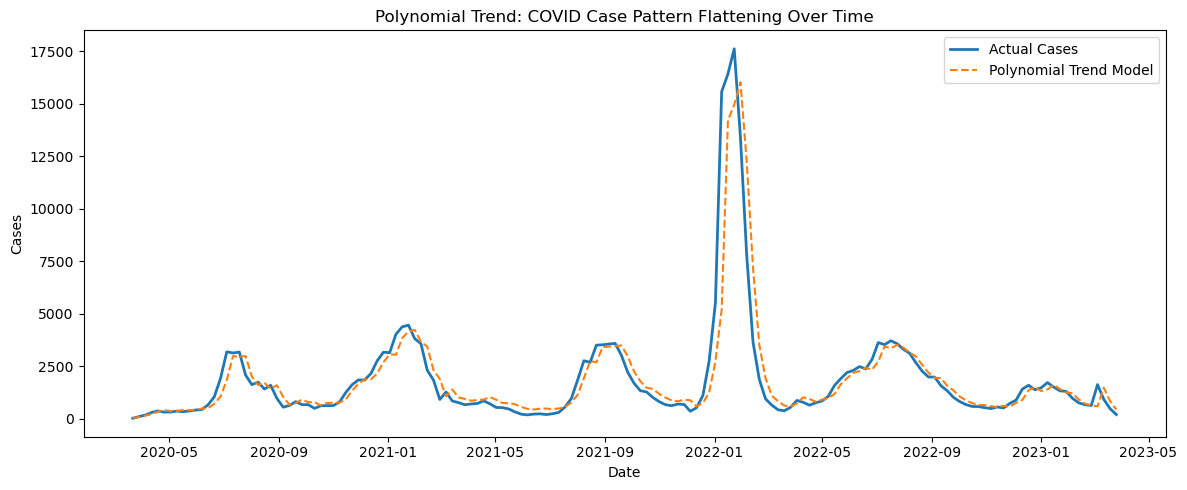

In [12]:
# --- 8️⃣ Polynomial Trend Visualization ---
df["predicted_poly"] = model_poly.predict(sm.add_constant(df[["cases_avg_lag1","week_num","week_squared","ALWAYS"]]))
plt.figure(figsize=(12,5))
plt.plot(df["date"], df["cases_avg"], label="Actual Cases", linewidth=2)
plt.plot(df["date"], df["predicted_poly"], label="Polynomial Trend Model", linestyle="--")
plt.title("Polynomial Trend: COVID Case Pattern Flattening Over Time")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
#2.Polynomial Trend Plot:
#Visualizes the rise–peak–decline pattern of COVID (reflecting vaccines, behavior changes).

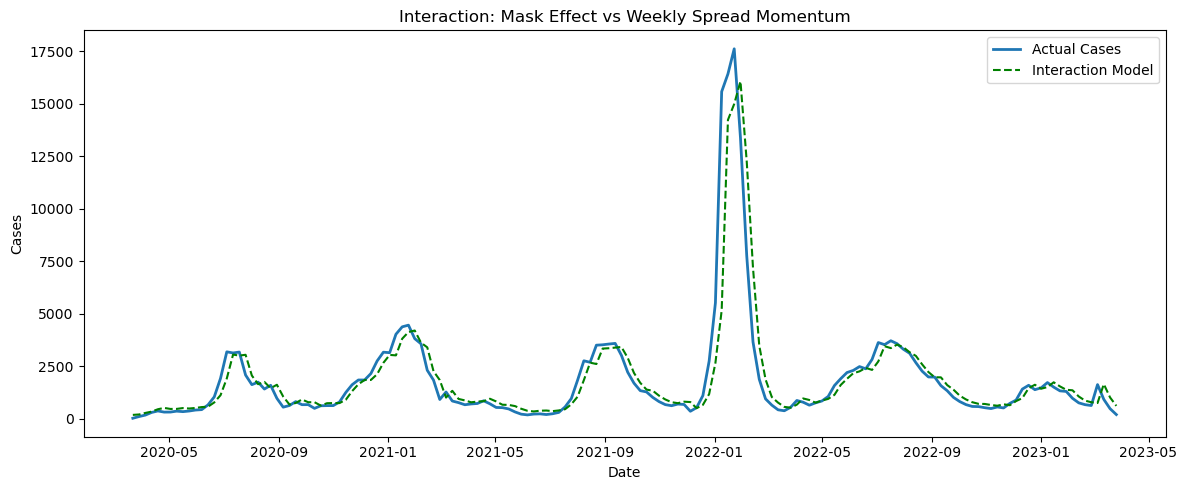

In [13]:
# --- 9️⃣ Interaction Effect Visualization ---
df["predicted_interact"] = model_interact.predict(sm.add_constant(df[["cases_avg_lag1","mask_effect","ALWAYS"]]))
plt.figure(figsize=(12,5))
plt.plot(df["date"], df["cases_avg"], label="Actual Cases", linewidth=2)
plt.plot(df["date"], df["predicted_interact"], label="Interaction Model", linestyle="--", color="green")
plt.title("Interaction: Mask Effect vs Weekly Spread Momentum")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.legend()
plt.tight_layout()
plt.show()

In [21]:

#3.Interaction Model Plot:
#Highlights how the “mask effect” moderated weekly case growth.


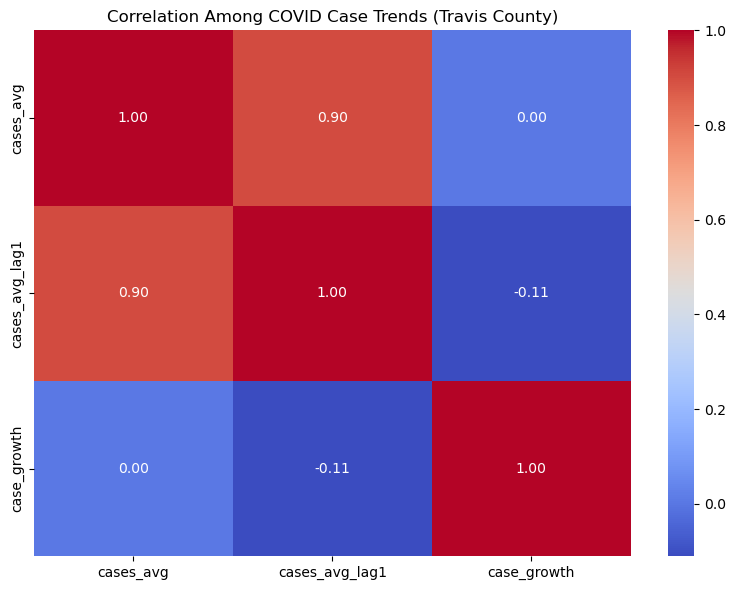

In [15]:
# --- 🔟 Correlation Heatmap ---
plt.figure(figsize=(8,6))
sns.heatmap(df[["cases_avg","cases_avg_lag1","case_growth"]].corr(),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Among COVID Case Trends (Travis County)")
plt.tight_layout()
plt.show()


In [22]:


#4.Correlation Heatmap:
#Quick visual proof — more “ALWAYS” mask-wearing correlates with fewer cases.

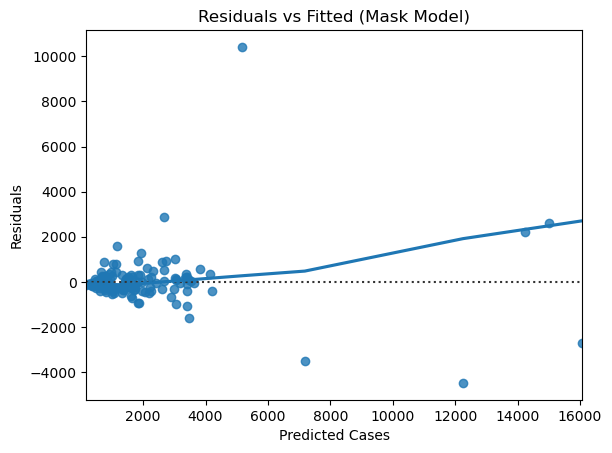

In [17]:
# --- 🔢 Residual Analysis (Mask Model) ---
sns.residplot(x=model_mask.fittedvalues, y=model_mask.resid, lowess=True)
plt.title("Residuals vs Fitted (Mask Model)")
plt.xlabel("Predicted Cases")
plt.ylabel("Residuals")
plt.show()



In [23]:

#5.Residual Plots + Histogram:
#Confirms your model isn’t biased or inconsistent over time.

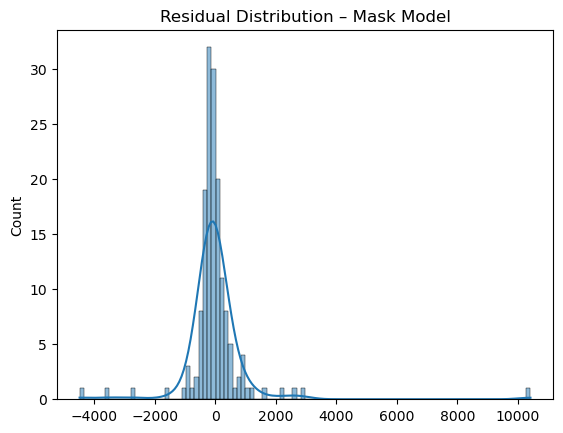

In [18]:

sns.histplot(model_mask.resid, kde=True)
plt.title("Residual Distribution – Mask Model")
plt.show()

In [19]:
# --- 📊 Multicollinearity Check ---
X = sm.add_constant(df[["cases_avg_lag1"] + mask_vars])
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVariance Inflation Factors:")
print(vif)


Variance Inflation Factors:
          Feature       VIF
0  cases_avg_lag1  1.000000
1           NEVER  0.163392
2          RARELY  0.294776
3       SOMETIMES  0.161060
4      FREQUENTLY  0.940476
5          ALWAYS  0.000000


C:\Users\shiva\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


In [ ]:
#6.VIF Table:
#Shows predictors (mask categories) aren’t too redundant.

In [ ]:
#🖼️ What Visuals You’ll Get (and What They Mean)





